In [1]:
import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


# 2. Dense Model

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

experiment = electrons + photons + pi0 + pi_char
del electrons, photons, pi0, pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592160


In [12]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    # "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}


experiment.train_xgboost_model(params)

(318433, 22)
INFO: Trained XGBoost model; mean squared error: 3655.5840579032492


3655.5840579032492

In [13]:
utils.count_nodes(experiment.model)

36658

In [34]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

x_e1, y_e1, x_u_e1, u_e1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p1, y_p1, x_u_p1, u_p1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi01, y_pi01, x_u_pi01, u_pi01 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char1, y_pi_char1, x_u_pi_char1, u_pi_char1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

In [15]:
X_train = experiment.X_train
Y_train = experiment.y_train
X_test = experiment.X_test
Y_test = experiment.y_test

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(120, input_shape=X_train[0].shape, activation="relu"))

# dense layers
model.add(keras.layers.Dense(80, activation="relu"))
model.add(keras.layers.Dense(40, activation="relu"))
model.add(keras.layers.Dense(28, activation="relu"))
model.add(keras.layers.Dense(4, activation="relu"))
model.add(keras.layers.Dense(1))  # 1 outout for z

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mse"],
)

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               2760      
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                                 
 dense_3 (Dense)             (None, 28)                1148      
                                                                 
 dense_4 (Dense)             (None, 4)                 116       
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 16,949
Trainable params: 16,949
Non-traina

In [17]:
# train model
history = model.fit(
    X_train, Y_train, validation_data=(X_test, Y_test), epochs=35, batch_size=32
)

Epoch 1/35
39804/39804 [==============================] - 42s 1ms/step - loss: 5353.4727 - mse: 5353.4727 - val_loss: 4400.0498 - val_mse: 4400.0498
Epoch 2/35
39804/39804 [==============================] - 41s 1ms/step - loss: 4256.1377 - mse: 4256.1377 - val_loss: 3980.6765 - val_mse: 3980.6765
Epoch 3/35
39804/39804 [==============================] - 41s 1ms/step - loss: 4032.9663 - mse: 4032.9663 - val_loss: 3871.6519 - val_mse: 3871.6519
Epoch 4/35
39804/39804 [==============================] - 41s 1ms/step - loss: 3904.3289 - mse: 3904.3289 - val_loss: 3722.8398 - val_mse: 3722.8398
Epoch 5/35
39804/39804 [==============================] - 41s 1ms/step - loss: 3818.6694 - mse: 3818.6694 - val_loss: 3736.5720 - val_mse: 3736.5720
Epoch 6/35
39804/39804 [==============================] - 41s 1ms/step - loss: 3757.1653 - mse: 3757.1653 - val_loss: 3656.3174 - val_mse: 3656.3174
Epoch 7/35
39804/39804 [==============================] - 41s 1ms/step - loss: 3709.4229 - mse: 3709.4229 

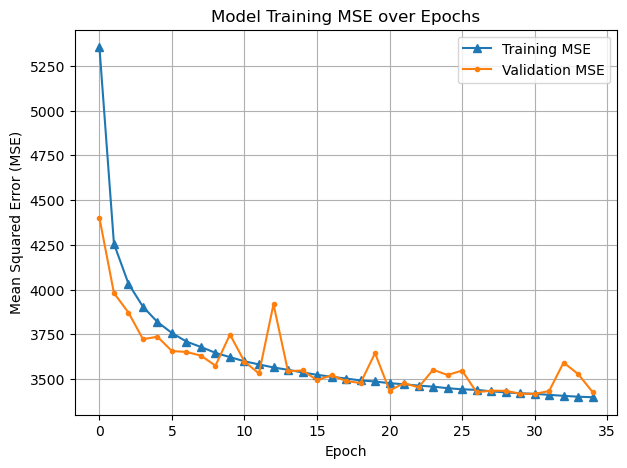

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(history.history["mse"], "^-", label="Training MSE")

plt.plot(history.history["val_mse"], ".-", label="Validation MSE")


plt.xlabel("Epoch")

plt.ylabel("Mean Squared Error (MSE)")
plt.grid()

plt.title("Model Training MSE over Epochs")

plt.legend(loc="best")


plt.show()

In [19]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(
    Y_pred.shape[0],
)

9952/9952 [==============================] - 6s 637us/step


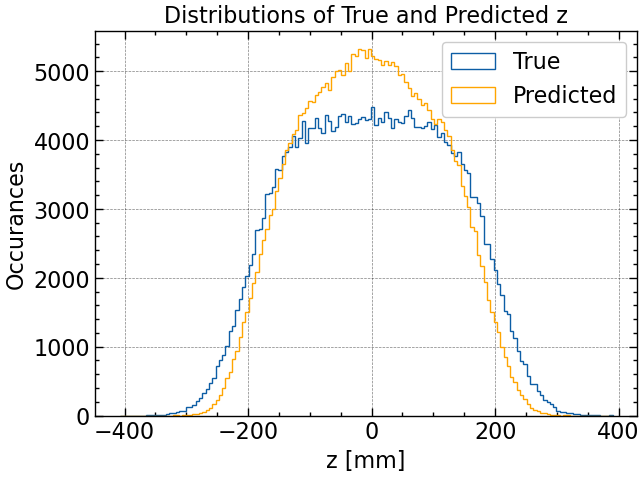

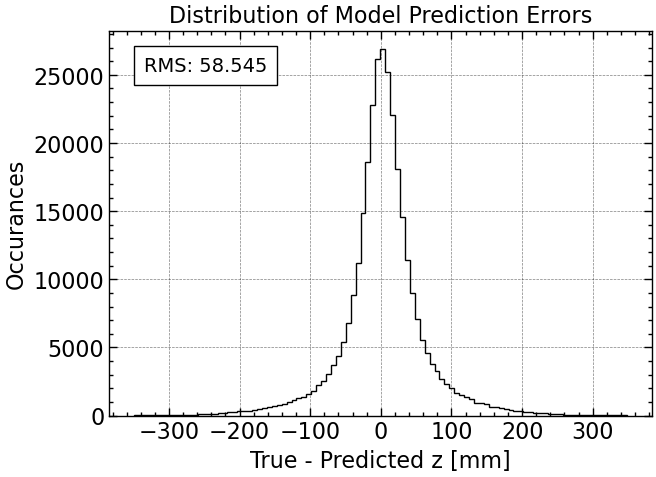

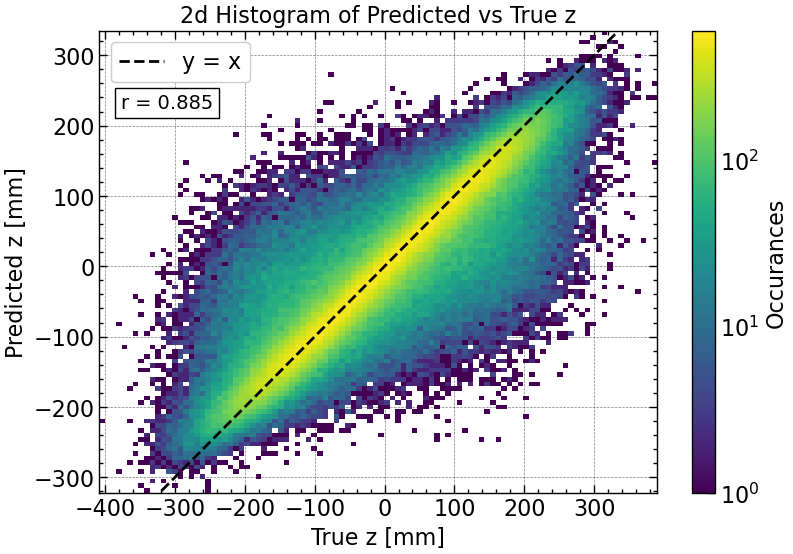

In [41]:
utils.plot_predictions(Y_test, Y_pred)
utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)
utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

In [21]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

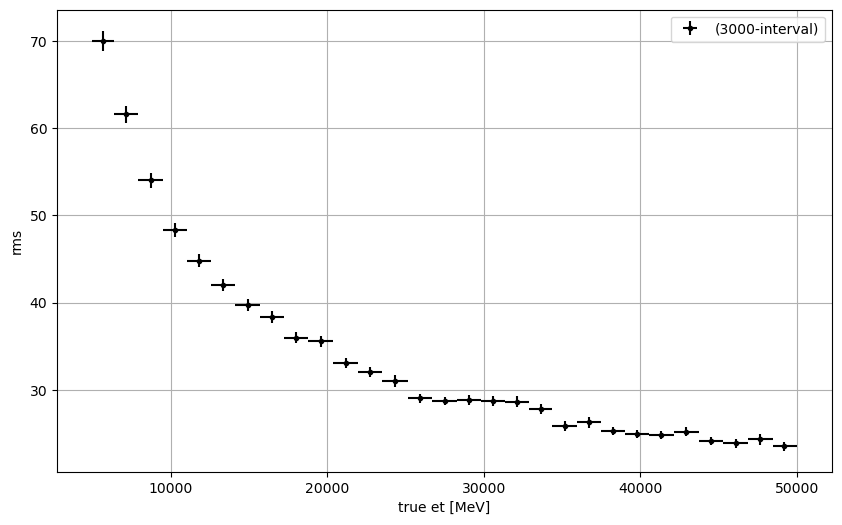

In [22]:
utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(Y_test - Y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

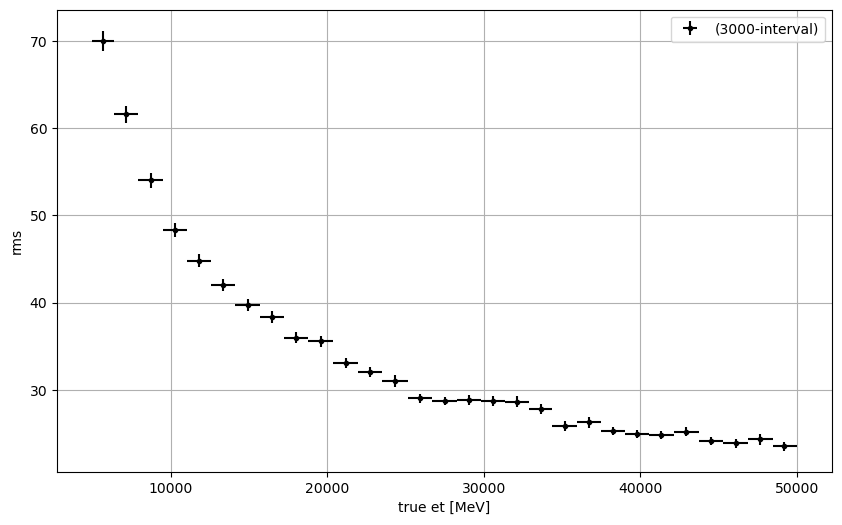

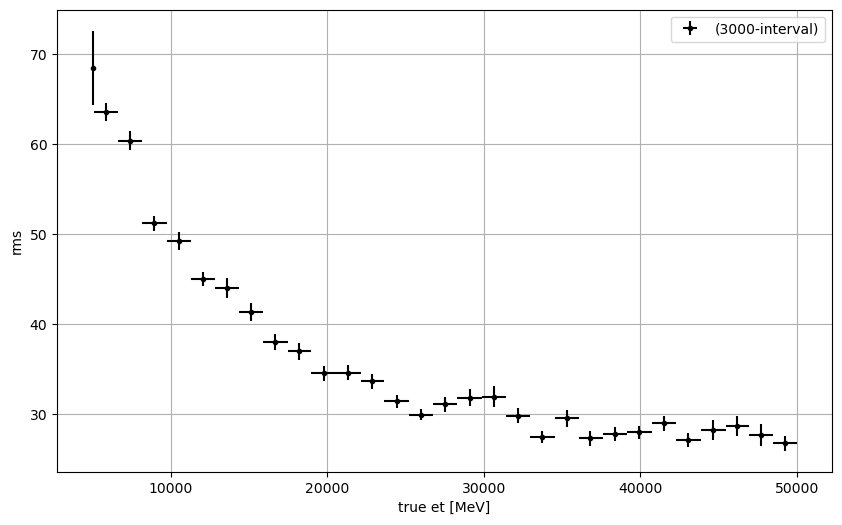

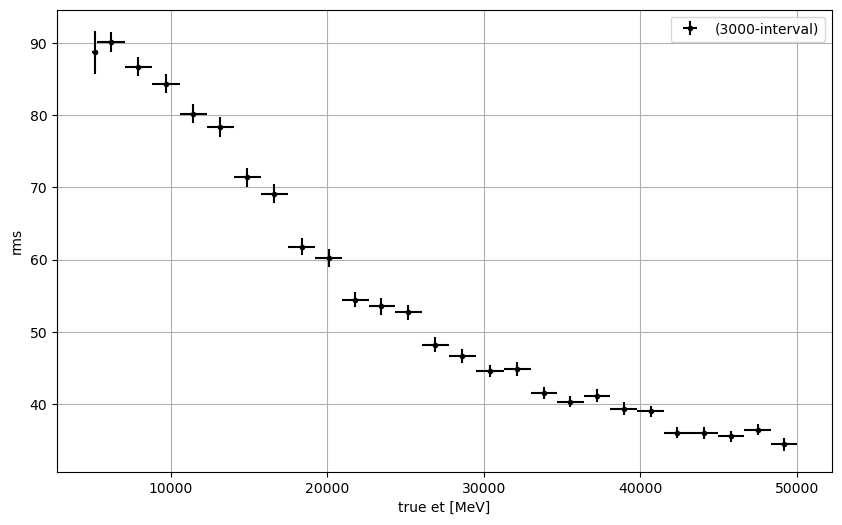

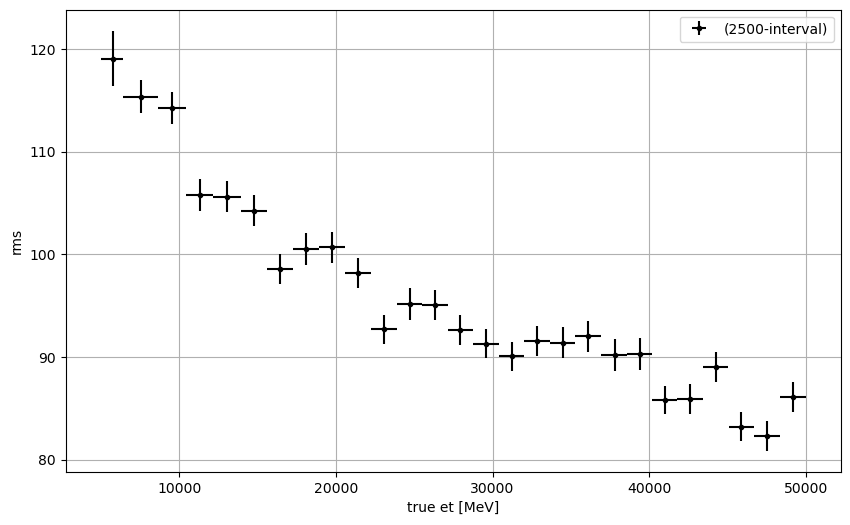

In [35]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(Y_test - Y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

x_p, y_p, x_u_p, u_p = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(Y_test - Y_pred)[mask_p],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi0, y_pi0, x_u_pi0, u_pi0 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(Y_test - Y_pred)[mask_pi0],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi_char, y_pi_char, x_u_pi_char, u_pi_char = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(Y_test - Y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

In [24]:
X_train.shape

(1273728, 22)

In [25]:
feature_names = [
    "psb eta",
    "emb1 eta",
    "emb2 eta",
    "emb3 eta",
    "hab1 eta",
    "psb - emb1 eta",
    "emb1 - emb2 eta",
    "emb2 - emb3 eta",
    "emb3 - hab1 eta",
    "psb(4)",
    "psb(5) - psb(3)",
    "emb1(8)",
    "emb1(9) - emb1(7)",
    "emb1(10) - emb1(6)",
    "emb1(11) - emb1(5)",
    "emb1(12) - emb1(4)",
    "emb2(4)",
    "emb2(5) - emb2(3)",
    "emb3(4)",
    "emb3(5) - emb3(3)",
    "hab1(4)",
    "hab1(5) - hab1(3)",
]

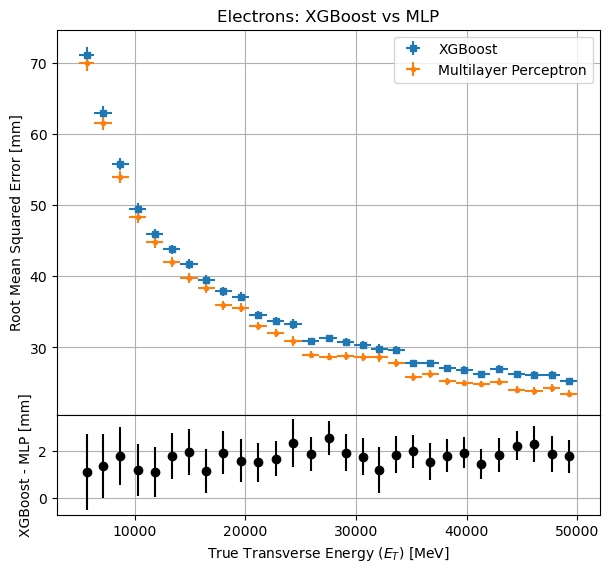

In [42]:
plt.figure(figsize=(7, 5))

# First plot
plt.errorbar(
    x_e1,
    y_e1,
    xerr=x_u_e1,
    yerr=u_e1,
    fmt="s",
    markersize=4,
    label="XGBoost",
)

# Second plot
plt.errorbar(
    x_e,
    y_e,
    xerr=x_u_e,
    yerr=u_e,
    fmt=".",
    label="Multilayer Perceptron",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Electrons: XGBoost vs MLP")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_e1) - np.array(y_e)

# Plot the differences
plt.errorbar(
    x_e,
    differences,
    yerr=np.sqrt(u_e**2 + u_e1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("XGBoost - MLP [mm]")

plt.grid()
plt.show()

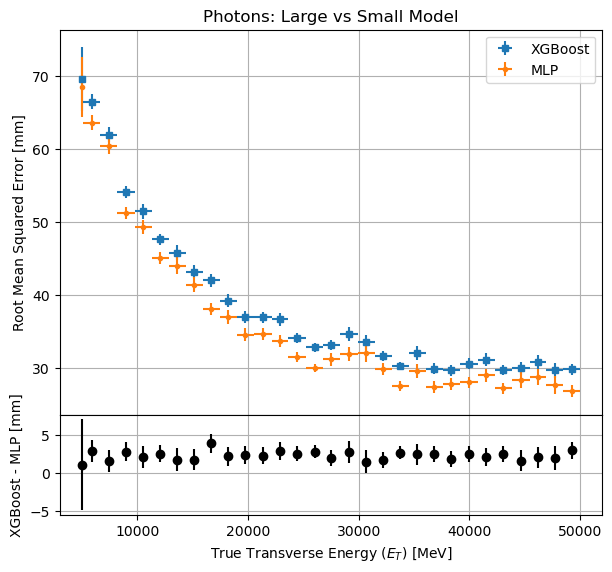

In [37]:
plt.figure(figsize=(7, 5))

# First plot
plt.errorbar(
    x_p1,
    y_p1,
    xerr=x_u_p1,
    yerr=u_p1,
    fmt="s",
    markersize=4,
    label="XGBoost",
)

# Second plot
plt.errorbar(
    x_p,
    y_p,
    xerr=x_u_p,
    yerr=u_p,
    fmt=".",
    label="MLP",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Photons: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_p1) - np.array(y_p)

# Plot the differences
plt.errorbar(
    x_p,
    differences,
    yerr=np.sqrt(u_p**2 + u_p1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("XGBoost - MLP [mm]")

plt.grid()
plt.show()

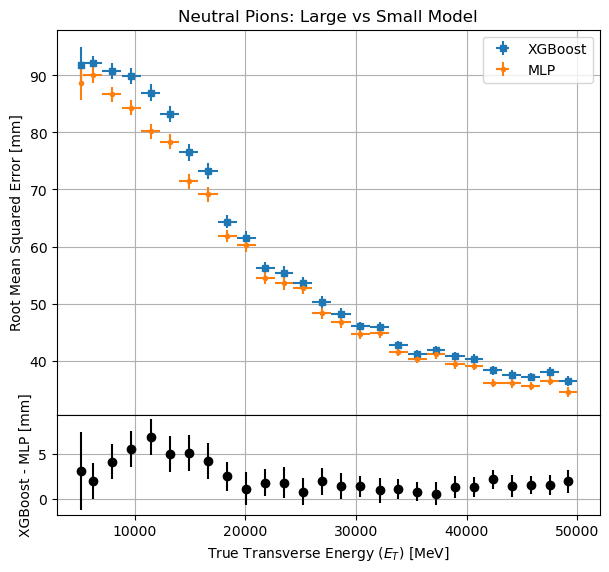

In [38]:
plt.figure(figsize=(7, 5))

# First plot
plt.errorbar(
    x_pi01,
    y_pi01,
    xerr=x_u_pi01,
    yerr=u_pi01,
    fmt="s",
    markersize=4,
    label="XGBoost",
)

# Second plot
plt.errorbar(
    x_pi0,
    y_pi0,
    xerr=x_u_pi0,
    yerr=u_pi0,
    fmt=".",
    label="MLP",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Neutral Pions: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi01) - np.array(y_pi0)

# Plot the differences
plt.errorbar(
    x_pi0,
    differences,
    yerr=np.sqrt(u_pi0**2 + u_pi01**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("XGBoost - MLP [mm]")

plt.grid()
plt.show()

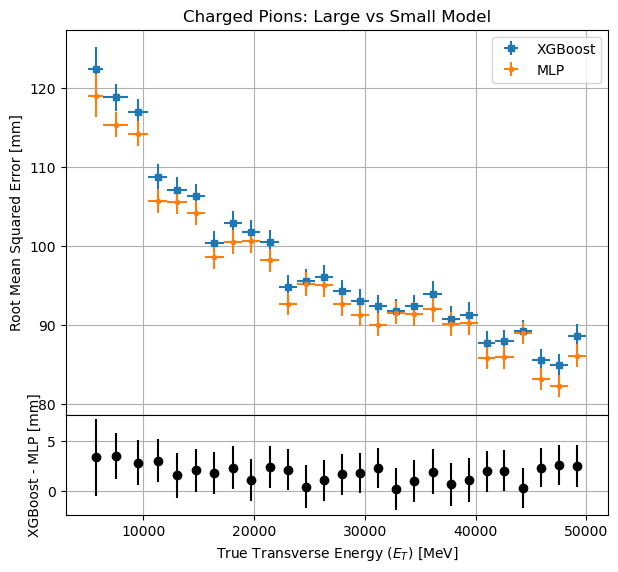

In [40]:
plt.figure(figsize=(7, 5))

# First plot
plt.errorbar(
    x_pi_char1,
    y_pi_char1,
    xerr=x_u_pi_char1,
    yerr=u_pi_char1,
    fmt="s",
    markersize=4,
    label="XGBoost",
)

# Second plot
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="MLP",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Charged Pions: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi_char1) - np.array(y_pi_char)

# Plot the differences
plt.errorbar(
    x_pi_char,
    differences,
    yerr=np.sqrt(u_pi_char**2 + u_pi_char1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("XGBoost - MLP [mm]")

plt.grid()
plt.show()